In [17]:
import torch
import torchvision.transforms as transforms # MNIST 데이터를 텐서 형태로 바꾸기 위해
import torch.nn.init

device = None
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 랜덤 시드 고정
torch.cuda.manual_seed_all(777)

# 현재 디바이스가 무엇인지?
print('Current Device : ' + str(device))

Current Device : mps


In [1]:
import os
import torchvision.datasets as dsets # 이 안에 MNIST 있다

if os.path.exists('MNIST'):
    mnist_train = dsets.MNIST(root=str(os.getcwd()), train=True, transform=transforms.ToTensor(), download=False)
    mnist_test = dsets.MNIST(root=str(os.getcwd()), train=False, transform=transforms.ToTensor(), download=False)
else: # MNIST 데이터 다운로드
    mnist_train = dsets.MNIST(root=str(os.getcwd()), train=True, transform=transforms.ToTensor(), download=True)
    mnist_test = dsets.MNIST(root=str(os.getcwd()), train=False, transform=transforms.ToTensor(), download=True)

print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/leejunseo/NODE
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/leejunseo/NODE
    Split: Test


In [19]:
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [33]:
from torchinfo import summary

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(784, 300)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(300,10)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, input):
        temp = self.flatten(input)
        temp = self.fc1(temp)
        temp = self.relu(temp)
        temp = self.fc2(temp)
        output = self.softmax(temp)
        return output
    
model = MLP()
model.to(device)
summary(model, (100,1,28,28))

/opt/anaconda3/envs/node/lib/python3.10/site-packages/torchinfo/torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/opt/anaconda3/envs/node/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super(TypedStorage, self).__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [100, 10]                 --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 300]                235,500
├─ReLU: 1-3                              [100, 300]                --
├─Linear: 1-4                            [100, 10]                 3,010
├─Softmax: 1-5                           [100, 10]                 --
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
Total mult-adds (M): 23.85
Input size (MB): 0.31
Forward/backward pass size (MB): 0.25
Params size (MB): 0.95
Estimated Total Size (MB): 1.52

In [30]:
def save_model(model: torch.nn.Module, name:str):
    path = './' + name + '.pth'
    torch.save(model.state_dict(), path)

def testAccuracy(model:torch.nn.Module, test_loader):
    model.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


In [31]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# 학습
EPOCH = 10
LR = 1e-3
accum_loss = 0
train_loss_arr = []
test_loss_arr = []
accum_acc = 0
acc_arr = []

loss_func = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCH):
    model.train()
    with tqdm(total=len(train_loader), desc='Train') as pbar:
        for x,y in train_loader:
            train_output = model(x.to(device))
            optimizer.zero_grad()
            train_loss = loss_func(train_output, y.to(device))
            train_loss.backward()
            accum_loss += train_loss.cpu().item()
            optimizer.step()
            pbar.update(1)
    cur_train_loss = accum_loss/len(train_loader) # (아마도) loss는 미니배치 한 개에 들어있는 데이터 개수 만큼의 loss를 의미할 것임.
    train_loss_arr.append(cur_train_loss)
    accum_loss = 0
        
    model.eval()
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc='Evaluation') as pbar:
            for x,y in test_loader:
                test_output = model(x.to(device))
                test_loss = loss_func(test_output, y.to(device))
                accum_loss += test_loss.cpu().item()
                max_prob, pred_idx = torch.max(test_output.data, 1)
                accum_acc += (pred_idx.cpu() == y).sum().item()
                pbar.update(1)
    cur_test_loss = accum_loss/len(test_loader)
    test_loss_arr.append(cur_test_loss)
    cur_acc = 100*accum_acc/len(test_loader.dataset)
    acc_arr.append(cur_acc)
    accum_loss = 0
    accum_acc = 0
    print("Epoch [{}/{}] Train_Loss: {:.4f}, Test_Loss: {:.4f}, Test_acc: {:.2f}".format(epoch+1, EPOCH, cur_train_loss,cur_test_loss, cur_acc))


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 107.29it/s]


Epoch [1/10] Train_Loss: 1.6019, Test_Loss: 1.5329, Test_acc: 93.56


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 108.53it/s]


Epoch [2/10] Train_Loss: 1.5255, Test_Loss: 1.5165, Test_acc: 94.94


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 107.21it/s]


Epoch [3/10] Train_Loss: 1.5083, Test_Loss: 1.5067, Test_acc: 95.92


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 108.44it/s]


Epoch [4/10] Train_Loss: 1.4994, Test_Loss: 1.4991, Test_acc: 96.50


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 108.11it/s]


Epoch [5/10] Train_Loss: 1.4923, Test_Loss: 1.4944, Test_acc: 96.87


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 107.85it/s]


Epoch [6/10] Train_Loss: 1.4872, Test_Loss: 1.4944, Test_acc: 96.98


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 108.09it/s]


Epoch [7/10] Train_Loss: 1.4837, Test_Loss: 1.4886, Test_acc: 97.44


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 111.34it/s]


Epoch [8/10] Train_Loss: 1.4811, Test_Loss: 1.4880, Test_acc: 97.44


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 103.78it/s]


Epoch [9/10] Train_Loss: 1.4792, Test_Loss: 1.4852, Test_acc: 97.80


Evaluation: 100%|██████████| 100/100 [00:00<00:00, 107.36it/s]

Epoch [10/10] Train_Loss: 1.4769, Test_Loss: 1.4848, Test_acc: 97.77


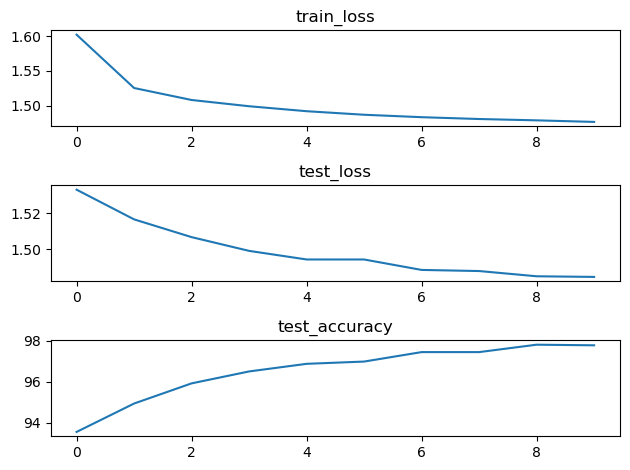

In [32]:
plt.subplot(3,1,1)
plt.plot(range(len(train_loss_arr)), train_loss_arr)
plt.title('train_loss')
plt.subplot(3,1,2)
plt.plot(range(len(test_loss_arr)), test_loss_arr)
plt.title('test_loss')
plt.subplot(3,1,3)
plt.plot(range(len(acc_arr)), acc_arr)
plt.title('test_accuracy')
plt.tight_layout()
plt.show()